In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Dataset
mortality = pd.read_parquet("../../01_Data/02_Processed/03_Mortality_Final.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
12221,Wisconsin,WI,SAUK,55111,2006,6,59580.0,0.000101
4998,Michigan,MI,MONROE,26115,2008,22,152806.0,0.000144
8459,Ohio,OH,WOOD,39173,2010,9,125956.0,0.000071
10733,Texas,TX,PARKER,48367,2015,15,125691.0,0.000119
4113,Louisiana,LA,RAPIDES,22079,2010,10,131742.0,0.000076


In [4]:
# Mortality Multiplier
mort_mul = 100000
mortality["Mortality_mul"] = mortality["Mortality_Rate"] * mort_mul

# Global Setting for ylabels so that they are consistent across all plots
ylabels = f"Mortality per {mort_mul:,} Population"

In [5]:
# Subset the dataset for the analysis
def prepare_data(
    dataset, test_state, control_states, policy_year, start_year, end_year
):
    # Filter states
    state_list = [test_state] + control_states
    sub_dataset = dataset[dataset["State_Code"].isin(state_list)]

    # Filter years
    sub_dataset = sub_dataset[
        (sub_dataset["Year"] >= start_year) & (sub_dataset["Year"] <= end_year)
    ]

    # Tagging for pre-post policy implementation and test-control
    sub_dataset["policy_implementation"] = sub_dataset["Year"] >= policy_year
    sub_dataset["State_Type"] = sub_dataset["State_Code"].apply(
        lambda x: "Test" if x == test_state else "Control"
    )

    return sub_dataset

In [6]:
def plot_pre_post_policy_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    sns.regplot(
        data=dataset[
            (dataset["State_Code"] == test_state)
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    ax.axvline(policy_year, ls="--", color="orange")

    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Pre-Policy"),
            mlines.Line2D([], [], color="red", label="Post-Policy"),
        ],
        loc="lower right",
    )

    plt.title(f"Pre-Post Policy Implementation Trend for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [7]:
def plot_diff_in_diff_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] != True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] == True)
        ],
        x="Year",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    plt.legend(handles=[blue_line, red_line], loc="lower right")
    plt.title(f"Difference-in-Difference Analysis for Mortality: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [8]:
def plot_all_states(dataset_in, test_state, policy_year, metric_column):
    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    # dataset["YEAR"] = dataset["YEAR"].astype("float64")
    # dataset[metric_column] = dataset[metric_column].astype("float64")

    plot = sns.lmplot(
        data=dataset,
        x="Year",
        y=metric_column,
        hue="policy_implementation",
        legend=False,
        row="State_Code",
    )

    # Set titles for each subplot
    plot = plot.set_titles("{row_name}")

    plt.legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, -0.15),
        title="Policy Implementation",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    ax.axvline(policy_year, ls="--", color="red")
    ax.set_ylabel(ylabels)
    plt.show()

# Washington

In [9]:
# Creating control variables

# Enter the Test State Below
test_state = "WA"

# Enter list of states required below, Included the test state
control_states = ["IL", "IN", "OH"]

# Year control variable
policy_year = 2012  # year the policy was implemented
start_year = 2008  # desired start year for analysis
end_year = 2015  # desired end year for analysis

In [10]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
7877,Ohio,OH,ATHENS,39009,2008,9,64546.0,0.000139,13.943544,False,Control
3422,Indiana,IN,VANDERBURGH,18163,2014,28,182010.0,0.000154,15.383770,True,Control
2964,Illinois,IL,MCLEAN,17113,2011,10,170939.0,0.000059,5.850040,False,Control
2845,Illinois,IL,KANE,17089,2009,28,511273.0,0.000055,5.476526,False,Control
7919,Ohio,OH,CLARK,39023,2011,34,137823.0,0.000247,24.669322,False,Control


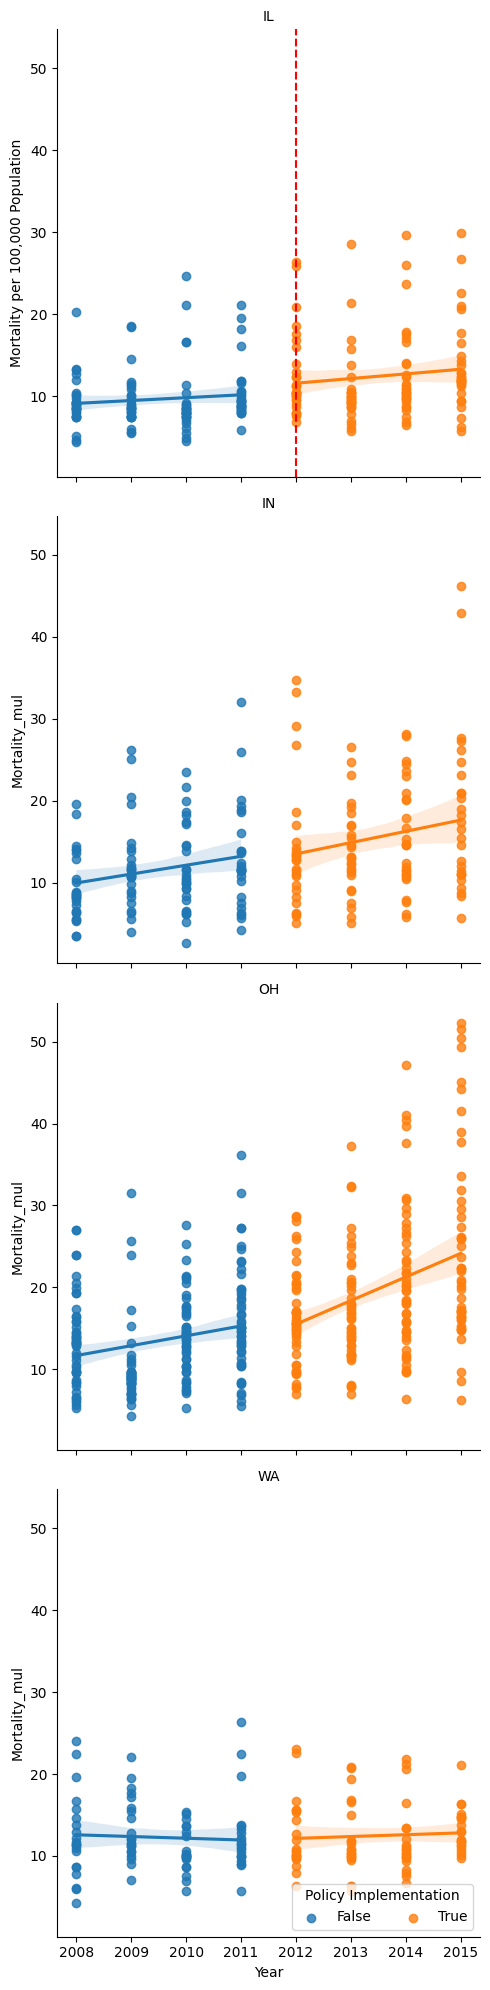

In [11]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

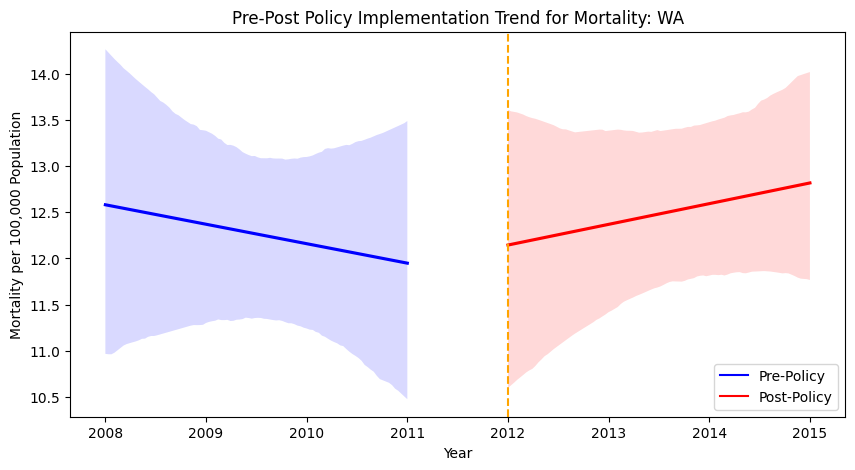

In [12]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

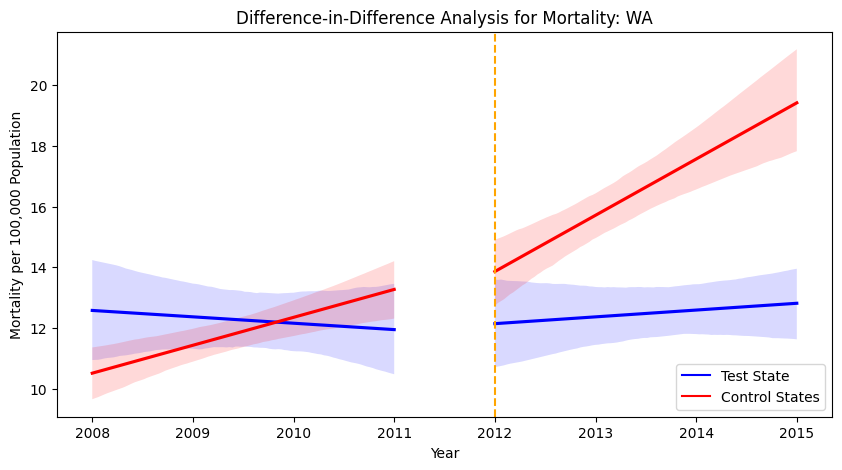

In [13]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Florida

In [14]:
# Creating control variables

# Enter the Test State Below
test_state = "FL"

# Enter list of states required below, Included the test state
control_states = ["GA", "NC", "MI"]

# Year control variable
policy_year = 2010  # year the policy was implemented
start_year = 2006  # desired start year for analysis
end_year = 2013  # desired end year for analysis

In [15]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
1623,Florida,FL,CLAY,12019,2006,15,178339.0,0.000084,8.410948,False,Test
1915,Florida,FL,PALM BEACH,12099,2010,193,1323631.0,0.000146,14.581103,True,Test
1588,Florida,FL,BROWARD,12011,2010,205,1752843.0,0.000117,11.695286,True,Test
7184,North Carolina,NC,BUNCOMBE,37021,2013,12,246952.0,0.000049,4.859244,True,Control
7301,North Carolina,NC,CRAVEN,37049,2013,16,104369.0,0.000153,15.330223,True,Control


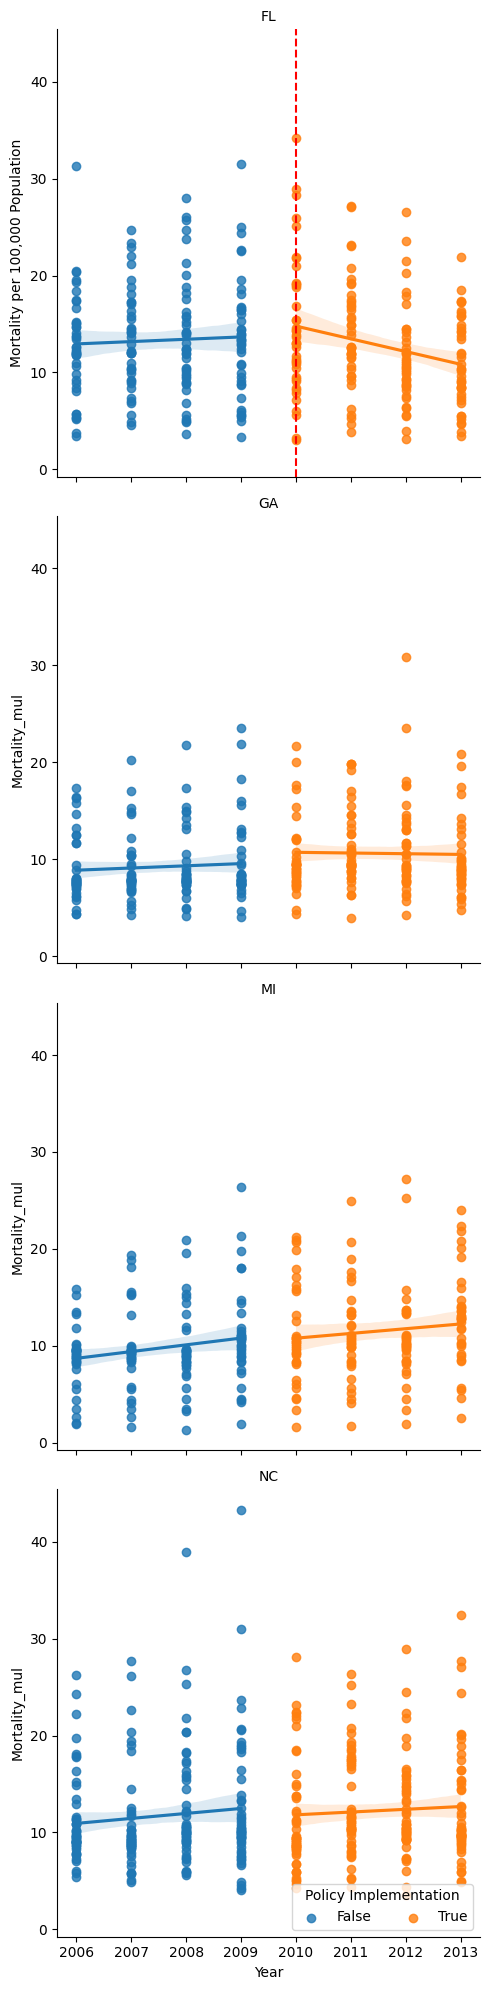

In [16]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

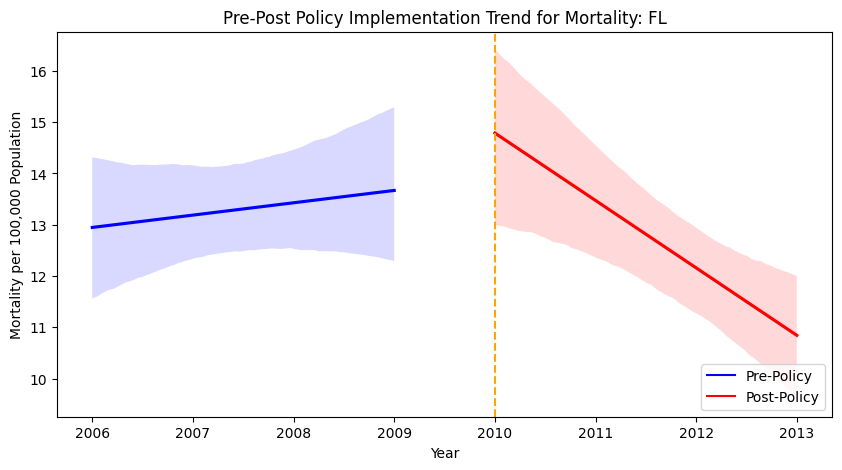

In [17]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

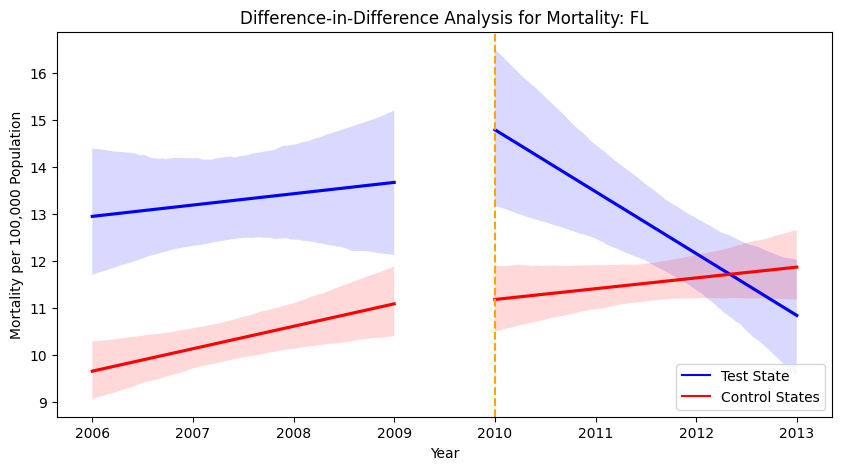

In [18]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

# Texas

In [19]:
# Creating control variables

# Enter the Test State Below
test_state = "TX"

# Enter list of states required below, Included the test state
control_states = ["OK", "AZ", "NM"]

# Year control variable
policy_year = 2007  # year the policy was implemented
start_year = 2003  # desired start year for analysis
end_year = 2011  # desired end year for analysis

In [20]:
mortality_plot = prepare_data(
    mortality, test_state, control_states, policy_year, start_year, end_year
)
mortality_plot.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,Mortality_mul,policy_implementation,State_Type
10958,Texas,TX,WISE,48497,2009,4,59134.0,0.000068,6.764298,True,Test
10709,Texas,TX,ORANGE,48361,2004,18,83580.0,0.000215,21.536253,False,Test
8617,Oklahoma,OK,TULSA,40143,2009,133,597748.0,0.000223,22.250179,True,Control
8546,Oklahoma,OK,MUSKOGEE,40101,2003,7,69666.0,0.000100,10.047943,False,Control
10815,Texas,TX,STARR,48427,2009,5,60384.0,0.000083,8.280339,True,Test


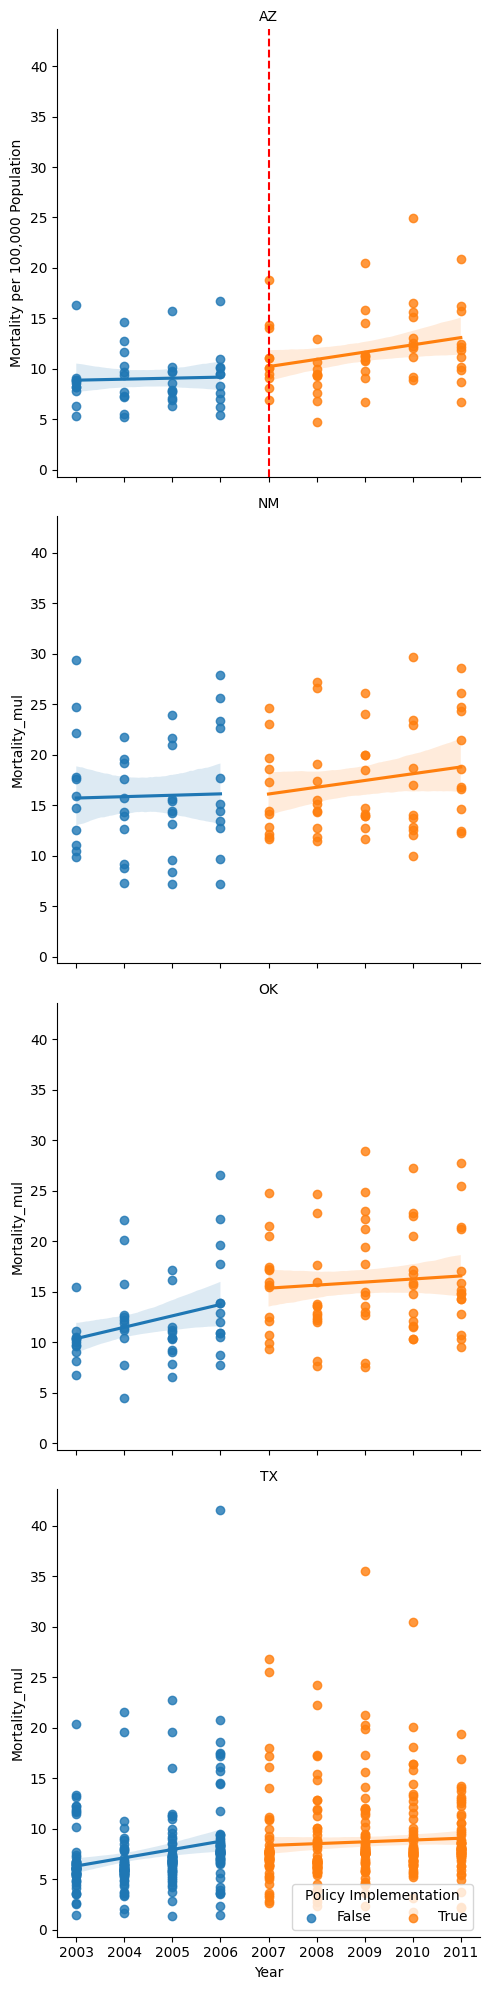

In [21]:
plot_all_states(mortality_plot, test_state, policy_year, "Mortality_mul")

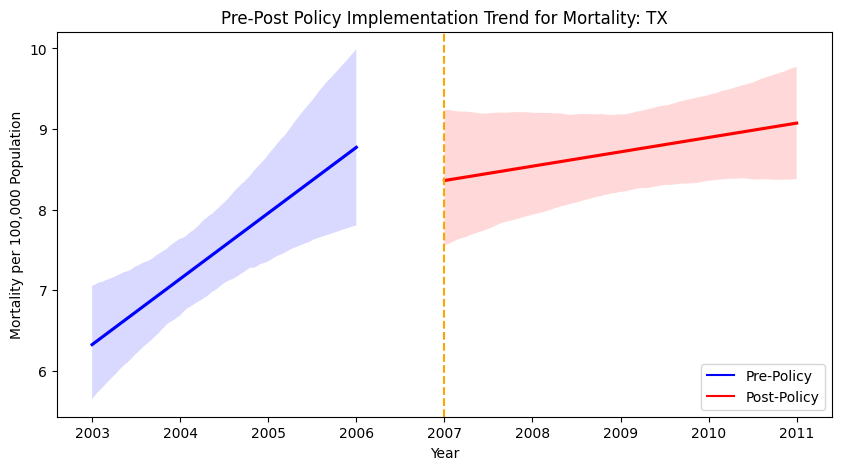

In [22]:
plot_pre_post_policy_graph(mortality_plot, test_state, policy_year, "Mortality_mul")

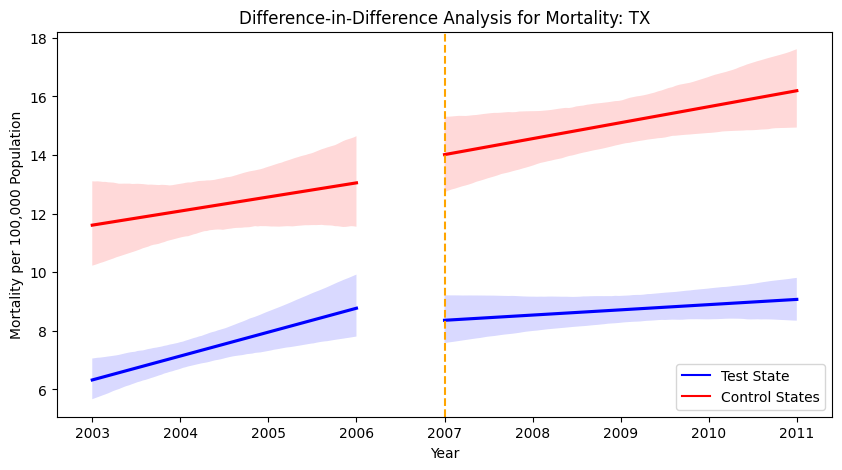

In [23]:
plot_diff_in_diff_graph(mortality_plot, test_state, policy_year, "Mortality_mul")